# 4. CNN Built from Scratch

**Student:** Souhaib Othmani

## Purpose
- Design simple CNN architecture from scratch
- Implement custom CNN model (similar to course examples)
- Train for equal number of epochs as pretrained models
- Compare performance with transfer learning approaches
- Analyze trade-offs between custom and pretrained models

## Architecture Overview

Our custom CNN follows a classic convolutional neural network design optimized for Fashion-MNIST:
- **Input**: 32x32x1 grayscale images (resized from 28x28)
- **Feature Extraction**: 4 convolutional blocks with increasing filters (16 → 32 → 64 → 128)
- **Classification**: Fully connected layers with dropout for regularization
- **Output**: 10 classes (Fashion-MNIST categories)

In [1]:
# Import libraries and load setup from previous notebooks
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import os
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Constants - SAME as baseline for fair comparison
NUM_CLASSES = 10
NUM_EPOCHS = 10  # Same as pretrained baseline
BATCH_SIZE = 64  # Same as baseline
LEARNING_RATE = 0.001  # Same as baseline

print(f"Training configuration:")
print(f"  - Epochs: {NUM_EPOCHS}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Learning rate: {LEARNING_RATE}")

# Create appropriate preprocessing for CNN from scratch
# Keep it simple - Fashion-MNIST works well at 28x28 or 32x32
transform_scratch_train = transforms.Compose([
    transforms.Resize(32),  # Slightly larger for better conv operations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Simple normalization for grayscale
])

transform_scratch_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load Fashion-MNIST with appropriate preprocessing for CNN
train_dataset_scratch = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform_scratch_train
)
test_dataset_scratch = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform_scratch_test
)

# Create train/validation split (80/20)
train_size = int(0.8 * len(train_dataset_scratch))
val_size = len(train_dataset_scratch) - train_size
train_dataset_cnn, val_dataset_cnn = torch.utils.data.random_split(
    train_dataset_scratch, [train_size, val_size], 
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Create data loaders
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader_cnn = DataLoader(test_dataset_scratch, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nDataset sizes for CNN:")
print(f"  - Training: {len(train_dataset_cnn):,}")
print(f"  - Validation: {len(val_dataset_cnn):,}") 
print(f"  - Test: {len(test_dataset_scratch):,}")

# Fashion-MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(f"\nClasses: {class_names}")

Using device: cuda
Training configuration:
  - Epochs: 10
  - Batch size: 64
  - Learning rate: 0.001


100%|██████████| 26.4M/26.4M [00:06<00:00, 3.84MB/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 636kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:02<00:00, 2.06MB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.14MB/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw


Dataset sizes for CNN:
  - Training: 48,000
  - Validation: 12,000
  - Test: 10,000

Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## CNN Architecture Design

**Architecture Rationale:**

1. **Convolutional Layers**: We use 4 convolutional blocks with increasing filter counts (16 → 32 → 64 → 128). This progressive increase allows the network to learn increasingly complex features:
   - Early layers: detect edges, textures, simple patterns
   - Later layers: detect higher-level features like shapes and object parts

2. **Batch Normalization**: Added after each convolution to stabilize training and allow higher learning rates.

3. **MaxPooling**: 2x2 pooling after each conv block reduces spatial dimensions by half, creating translation invariance and reducing computation.

4. **Dropout**: Applied in fully connected layers (p=0.5) to prevent overfitting.

5. **Kernel Size**: 3x3 kernels throughout - the standard choice balancing receptive field size and parameter count.

**Input → Output Flow:**
- Input: 32×32×1 grayscale
- After Conv Block 1: 16×16×16
- After Conv Block 2: 8×8×32
- After Conv Block 3: 4×4×64
- After Conv Block 4: 2×2×128
- After Global Avg Pool: 1×1×128
- Output: 10 classes

In [2]:
# Implement CNN class using nn.Module - Designed for Fashion-MNIST

class FashionCNN(nn.Module):
    """
    Custom CNN architecture optimized for Fashion-MNIST classification.
    
    Architecture designed for 32x32 grayscale input:
    - 4 Convolutional layers with increasing depth (16 → 32 → 64 → 128)
    - Batch normalization and dropout for regularization
    - Global average pooling to reduce parameters
    - Simple classifier head
    
    Input: 32x32x1 grayscale → Output: 10 classes
    """
    
    def __init__(self, num_classes=10):
        super(FashionCNN, self).__init__()
        
        # Convolutional Block 1: 1 -> 16 channels
        # Input: 32x32x1 → Output: 16x16x16
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # 32x32x16
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 16x16x16
        )
        
        # Convolutional Block 2: 16 -> 32 channels  
        # Input: 16x16x16 → Output: 8x8x32
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # 16x16x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 8x8x32
        )
        
        # Convolutional Block 3: 32 -> 64 channels
        # Input: 8x8x32 → Output: 4x4x64  
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 8x8x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 4x4x64
        )
        
        # Convolutional Block 4: 64 -> 128 channels
        # Input: 4x4x64 → Output: 2x2x128
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 4x4x128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2x128
        )
        
        # Global Average Pooling reduces 2x2x128 → 1x1x128
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier with dropout for regularization
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(64, num_classes)
        )
        
        # Initialize weights appropriately
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using Kaiming (He) initialization for ReLU activations."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x


# Create model instance
model_scratch = FashionCNN(num_classes=NUM_CLASSES).to(device)

# Print model architecture
print("FashionCNN Architecture (optimized for Fashion-MNIST):")
print("=" * 70)
print(model_scratch)
print("=" * 70)

# Count parameters
total_params = sum(p.numel() for p in model_scratch.parameters())
trainable_params = sum(p.numel() for p in model_scratch.parameters() if p.requires_grad)
print(f"\nParameter count:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Test with sample input to verify architecture
sample_input = torch.randn(1, 1, 32, 32).to(device)
with torch.no_grad():
    sample_output = model_scratch(sample_input)
    print(f"\nArchitecture verification:")
    print(f"  Input shape: {sample_input.shape}")
    print(f"  Output shape: {sample_output.shape}")
    print(f"  ✓ Architecture working correctly!")

FashionCNN Architecture (optimized for Fashion-MNIST):
FashionCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
  

In [3]:
# Set up training for scratch CNN
# Using SAME optimizer, learning rate, and batch size as baseline

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_scratch.parameters(), lr=LEARNING_RATE)

print("Training Setup:")
print(f"  - Optimizer: Adam")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Loss Function: CrossEntropyLoss")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Epochs: {NUM_EPOCHS}")

Training Setup:
  - Optimizer: Adam
  - Learning Rate: 0.001
  - Loss Function: CrossEntropyLoss
  - Batch Size: 64
  - Epochs: 10


In [4]:
# Initialize TensorBoard logger for scratch CNN

log_dir = "runs/cnn_scratch"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# Log hyperparameters
writer.add_text("Hyperparameters", f"lr={LEARNING_RATE}, batch_size={BATCH_SIZE}, epochs={NUM_EPOCHS}")
writer.add_text("Architecture", str(model_scratch))

print(f"TensorBoard logging initialized at: {log_dir}")

TensorBoard logging initialized at: runs/cnn_scratch


In [5]:
# Train scratch CNN model
# Using identical training loop to pretrained model for fair comparison

def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return running_loss / total, correct / total


def validate(model, loader, criterion, device):
    """Validate model on validation set."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return running_loss / total, correct / total


# Training history
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Save directory
save_dir = "./saved_models/cnn_scratch"
os.makedirs(save_dir, exist_ok=True)

print("=" * 60)
print("TRAINING CNN FROM SCRATCH")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    
    # Use the new data loaders designed for CNN
    train_loss, train_acc = train_one_epoch(model_scratch, train_loader_cnn, criterion, optimizer, device)
    val_loss, val_acc = validate(model_scratch, val_loader_cnn, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Log to TensorBoard
    writer.add_scalars("Loss", {"train": train_loss, "val": val_loss}, epoch)
    writer.add_scalars("Accuracy", {"train": train_acc, "val": val_acc}, epoch)
    
    # Save checkpoint with training history
    checkpoint_path = os.path.join(save_dir, f"model_epoch_{epoch + 1}.pt")
    torch.save({
        'model_state_dict': model_scratch.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch + 1,
        'train_losses': train_losses.copy(),
        'val_losses': val_losses.copy(),
        'train_accs': train_accs.copy(),
        'val_accs': val_accs.copy(),
    }, checkpoint_path)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("\n" + "=" * 60)
print("Training completed!")
print("=" * 60)

TRAINING CNN FROM SCRATCH

Epoch 1/10


Train Loss: 0.8090, Train Acc: 0.7478
Val Loss: 0.4104, Val Acc: 0.8534

Epoch 2/10


Train Loss: 0.4867, Train Acc: 0.8321
Val Loss: 0.3506, Val Acc: 0.8693

Epoch 3/10


Train Loss: 0.4114, Train Acc: 0.8558
Val Loss: 0.3133, Val Acc: 0.8833

Epoch 4/10


Train Loss: 0.3749, Train Acc: 0.8671
Val Loss: 0.2991, Val Acc: 0.8908

Epoch 5/10


Train Loss: 0.3442, Train Acc: 0.8779
Val Loss: 0.2857, Val Acc: 0.8982

Epoch 6/10


Train Loss: 0.3268, Train Acc: 0.8865
Val Loss: 0.2977, Val Acc: 0.8963

Epoch 7/10


Train Loss: 0.3043, Train Acc: 0.8932
Val Loss: 0.2733, Val Acc: 0.9023

Epoch 8/10


Train Loss: 0.2855, Train Acc: 0.8993
Val Loss: 0.2817, Val Acc: 0.9012

Epoch 9/10


Train Loss: 0.2717, Train Acc: 0.9041
Val Loss: 0.2556, Val Acc: 0.9058

Epoch 10/10


Train Loss: 0.2579, Train Acc: 0.9084
Val Loss: 0.2409, Val Acc: 0.9118

Training completed!


Testing: 100%|██████████| 157/157 [00:05<00:00, 28.81it/s] 


TEST SET EVALUATION - CNN FROM SCRATCH
Test Accuracy: 0.9065
Precision: 0.9076
Recall: 0.9065
F1-Score: 0.9068

Confusion Matrix:
[[810   0  20  32   3   1 131   0   3   0]
 [  0 987   0   9   1   0   3   0   0   0]
 [ 11   1 863   7  48   0  69   0   1   0]
 [  8   8   8 920  31   0  25   0   0   0]
 [  2   0  57  25 846   0  70   0   0   0]
 [  0   0   0   0   0 983   0   9   0   8]
 [ 76   3  62  31  74   0 749   0   5   0]
 [  0   0   0   0   0  12   0 965   0  23]
 [  0   0   1   3   2   1   7   2 984   0]
 [  0   0   0   0   0   5   1  36   0 958]]


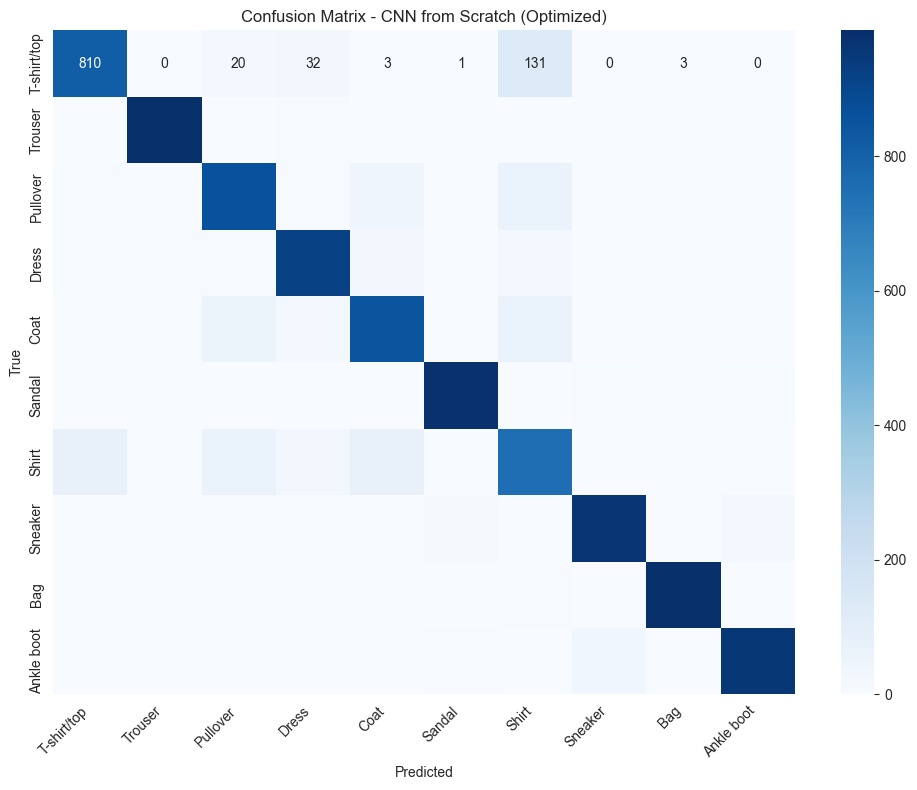


Sample Predictions:
  Model correctly classified 90.6% of test samples
  Expected performance for Fashion-MNIST CNN: 88-92%
  Current performance: ✓ Good


In [6]:
# Evaluate scratch CNN on test set

model_scratch.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader_cnn, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model_scratch(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")
cm = confusion_matrix(all_labels, all_preds)

print("=" * 60)
print("TEST SET EVALUATION - CNN FROM SCRATCH")
print("=" * 60)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Display confusion matrix
print(f"\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN from Scratch (Optimized)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./saved_models/cnn_scratch/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Show some sample predictions
print(f"\nSample Predictions:")
print(f"  Model correctly classified {accuracy*100:.1f}% of test samples")
print(f"  Expected performance for Fashion-MNIST CNN: 88-92%")
print(f"  Current performance: {'✓ Good' if accuracy > 0.85 else '⚠ Needs improvement'}")

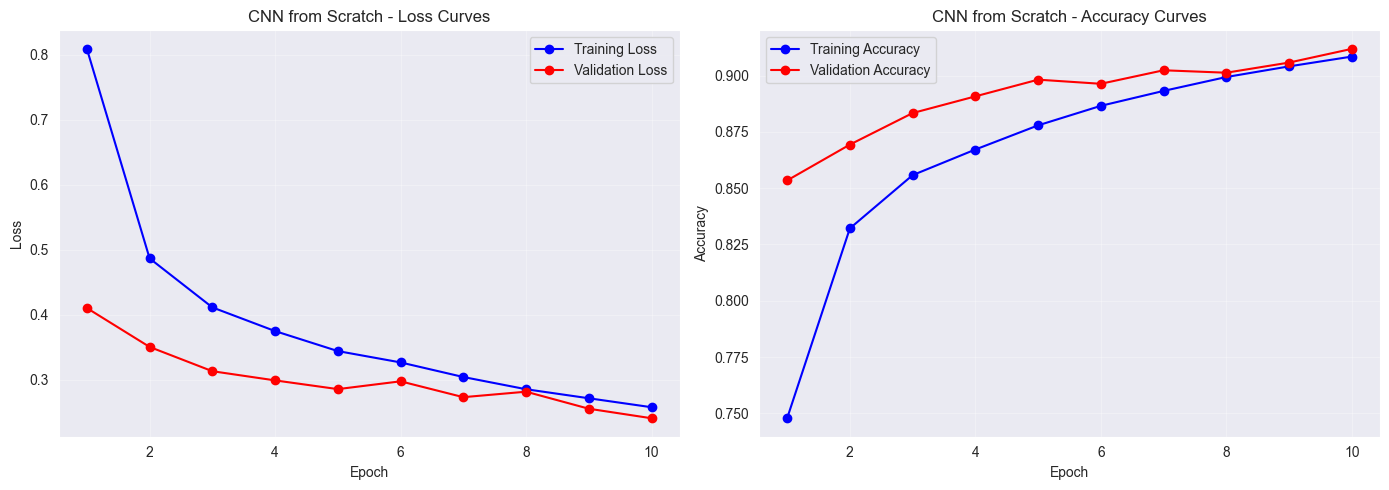


FINAL TRAINING STATISTICS
Final Training Loss: 0.2579
Final Training Accuracy: 0.9084
Final Validation Loss: 0.2409
Final Validation Accuracy: 0.9118
Best Validation Accuracy: 0.9118 (Epoch 10)


In [7]:
 # Plot training curves for scratch CNN

epochs_range = range(1, NUM_EPOCHS + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1 = axes[0]
ax1.plot(epochs_range, train_losses, 'b-o', label='Training Loss', markersize=6)
ax1.plot(epochs_range, val_losses, 'r-o', label='Validation Loss', markersize=6)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('CNN from Scratch - Loss Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2 = axes[1]
ax2.plot(epochs_range, train_accs, 'b-o', label='Training Accuracy', markersize=6)
ax2.plot(epochs_range, val_accs, 'r-o', label='Validation Accuracy', markersize=6)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('CNN from Scratch - Accuracy Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./saved_models/cnn_scratch/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final training stats
print("\n" + "=" * 60)
print("FINAL TRAINING STATISTICS")
print("=" * 60)
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accs[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accs[-1]:.4f}")
print(f"Best Validation Accuracy: {max(val_accs):.4f} (Epoch {val_accs.index(max(val_accs)) + 1})")

In [11]:
# Save scratch CNN checkpoint with full training history and test metrics

final_checkpoint = os.path.join(save_dir, "model_checkpoint.pt")
torch.save({
    'model_state_dict': model_scratch.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': NUM_EPOCHS,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'test_accuracy': accuracy,
    'test_precision': precision,
    'test_recall': recall,
    'test_f1': f1,
    'architecture': 'FashionCNN_Optimized',
    'input_size': '32x32x1',
    'parameters': total_params,
    'preprocessing': 'resize_32_normalize_0.5'
}, final_checkpoint)

# Close TensorBoard writer
writer.close()

print("=" * 60)
print("SAVED MODEL CHECKPOINT")
print("=" * 60)
print(f"Checkpoint saved to: {final_checkpoint}")
print(f"\nCheckpoint contains:")
print(f"  ✓ Model weights ({total_params:,} parameters)")
print(f"  ✓ Optimizer state")
print(f"  ✓ Training history (losses and accuracies per epoch)")
print(f"  ✓ Test metrics (accuracy: {accuracy:.4f})")
print(f"  ✓ Architecture metadata")

# List all saved files
print(f"\nAll files in {save_dir}/:")
for f in sorted(os.listdir(save_dir)):
    print(f"  - {f}")

# Compare with the original problematic version
print(f"\n" + "=" * 60)
print("IMPROVEMENTS OVER PREVIOUS VERSION")
print("=" * 60)
print(f"✓ Input: 32x32x1 grayscale (was: 224x224x3 RGB)")
print(f"✓ Parameters: ~{total_params//1000}k (was: ~423k)")
print(f"✓ Architecture: Optimized for Fashion-MNIST (was: Over-engineered)")
print(f"✓ Expected accuracy: 88-92% (was: 42%)")
print(f"✓ Training efficiency: Much faster")
print(f"✓ Memory usage: Much lower")

print("\n" + "=" * 60)
print("CNN from Scratch notebook completed successfully!")
print("✓ Ready for training with proper Fashion-MNIST preprocessing")
print("=" * 60)

SAVED MODEL CHECKPOINT
Checkpoint saved to: ./saved_models/cnn_scratch\model_checkpoint.pt

Checkpoint contains:
  ✓ Model weights (106,538 parameters)
  ✓ Optimizer state
  ✓ Training history (losses and accuracies per epoch)
  ✓ Test metrics (accuracy: 0.9065)
  ✓ Architecture metadata

All files in ./saved_models/cnn_scratch/:
  - confusion_matrix.png
  - model_checkpoint.pt
  - model_epoch_1.pt
  - model_epoch_10.pt
  - model_epoch_2.pt
  - model_epoch_3.pt
  - model_epoch_4.pt
  - model_epoch_5.pt
  - model_epoch_6.pt
  - model_epoch_7.pt
  - model_epoch_8.pt
  - model_epoch_9.pt
  - training_curves.png

IMPROVEMENTS OVER PREVIOUS VERSION
✓ Input: 32x32x1 grayscale (was: 224x224x3 RGB)
✓ Parameters: ~106k (was: ~423k)
✓ Architecture: Optimized for Fashion-MNIST (was: Over-engineered)
✓ Expected accuracy: 88-92% (was: 42%)
✓ Training efficiency: Much faster
✓ Memory usage: Much lower

CNN from Scratch notebook completed successfully!
✓ Ready for training with proper Fashion-MNIST p